<a href="https://colab.research.google.com/github/CShorten/Vector-Search-for-Data-Scientists/blob/main/Twitter_Weaviate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Twitter Analytics with Weaviate </h1>

This notebook is part of the series on <b>Vector Search for Data Science</b>.
<br />
We illustrate concrete details of this with Twitter Analytics.
<br />

Check out the recorded presentation of this notebook on YouTube: https://www.youtube.com/watch?v=IRWHa57T-zk

You can access your Twitter Analytics by going to more --> Twitter Analytics --> Export Data. This analytics is conducted via the "By Tweet" option. An illustration of the Twitter Analytics UI to download data is shown below:

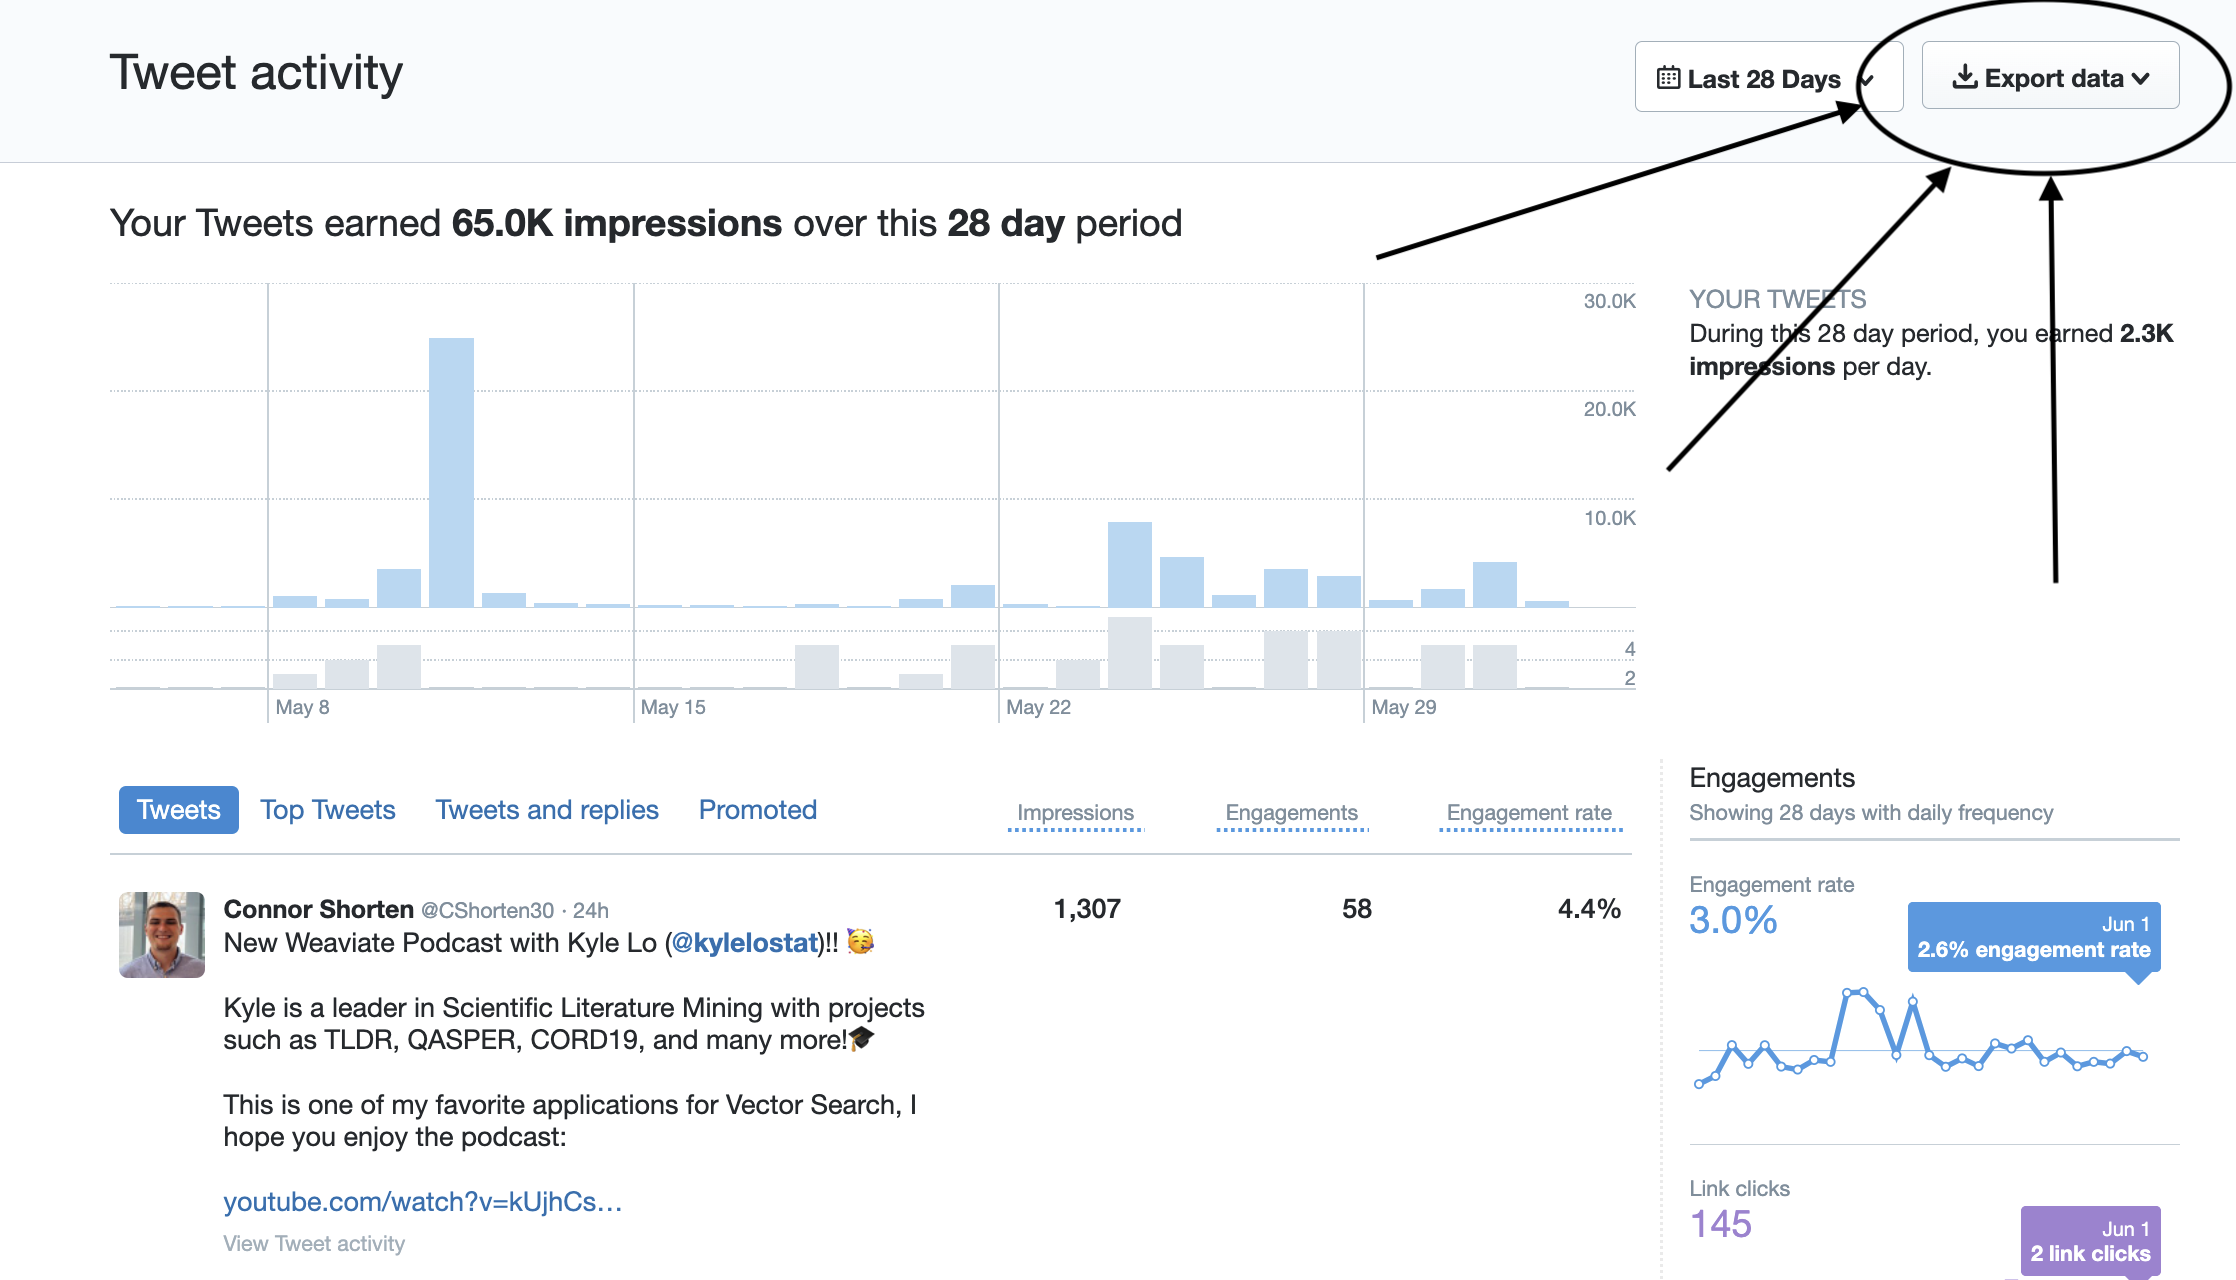

Once we have the data, we can drag and drop it into the local file system of our Colab notebook and visualize it with pandas!

In [ ]:
import pandas as pd

df = pd.read_csv("Connors-Tweets.csv")

df.head(2)

,Unnamed: 0,Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,...,promoted hashtag clicks,promoted detail expands,promoted permalink clicks,promoted app opens,promoted app installs,promoted follows,promoted email tweet,promoted dial phone,promoted media views,promoted media engagements
0,0,1524076482716442624,https://twitter.com/CShorten30/status/15240764...,@fchollet Nice! Love the idea of models that t...,2022-05-10 17:18 +0000,393.0,5.0,0.012723,0.0,0.0,...,-,-,-,-,-,-,-,-,-,-
1,1,1524027337234432000,https://twitter.com/CShorten30/status/15240273...,Connected Papers is definitely a useful tool f...,2022-05-10 14:03 +0000,27873.0,905.0,0.032469,45.0,3.0,...,-,-,-,-,-,-,-,-,-,-


The Twitter analytics contains the content of the Tweet as well as performance metrics!

In [ ]:
df.iloc[0]["Tweet text"]

'@fchollet Nice! Love the idea of models that take embeddings from some other optimization task as inputs! 🔥'

<h1> Visualize Distributions of Metrics </h1>

One of the core goals of Data Science is to understand the distribution of key metrics.<br />
Below we see a power-law distribution of impressions with our Tweets.

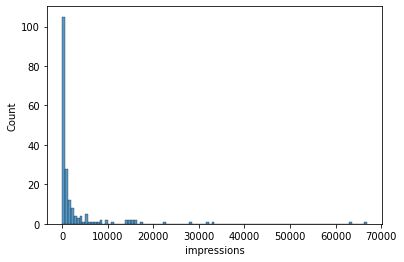

In [ ]:
import seaborn as sns
impressions = df["impressions"]

sns.histplot(impressions);

We see that a couple of Tweets have received much more distributions than the rest!
<br />
We can visualize the highest performing tweet quickly by indexing the max impressions shown below.

In [ ]:
import numpy as np
tweets = df["Tweet text"].to_numpy()
print(tweets[np.where(impressions == max(impressions))[0]][0])

This video explains some ideas around the OpenAI Embeddings API!

I had the opportunity to interview Arvind Neelakantan (@arvind_io) from OpenAI about these ideas and this video summarizes my takeaways and provides background for each topic.

https://t.co/rJymcSYx0t


We can also apply a log scale to our impressions histogram.
<br /> This enables us to get a better visualization of how values are distributed around 100-1,000 impressions.

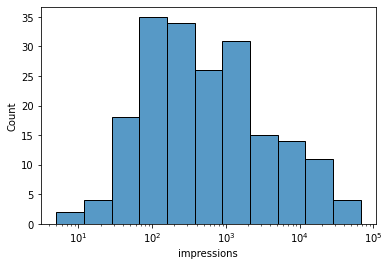

In [ ]:
sns.histplot(impressions, log_scale=True);

<h1> Segmenting Analytics </h1>
<br />
Segmentation is a common practice in Data Science in which we split the data based on the values of other variables.
<br />
This lets us ask questions about how our variables relate to Impressions? Answering questions such as:
<ul>
<li> How do Impressions relate to the <b> Time </b> the Tweet was published? </li>
<li> How do Impressions relate to wether the Tweet contains a <b> URL </b> </li>
</ul>

<h1> Segment by Time of Day </h1>

In [ ]:
import datetime
import calendar


def get_hour(date_str):
  return int(date_str.split(" ")[1].split(":")[0])

def get_minute(date_str):
  return int(date_str.split(" ")[1].split(":")[1])

def time_of_day_buckets(date_str):
  hour = get_hour(date_str)
  if hour > 12: # simple bucket for now
    return False
  else:
    return True

def get_weekday(date_str):
  vals = date_str.split(" ")[0].split("-")
  datetime_obj = datetime.datetime(int(vals[0]), int(vals[1]), int(vals[2]))
  return calendar.day_name[datetime_obj.weekday()]

df["hour"] = df["time"].apply(get_hour)
df["minute"] = df["time"].apply(get_minute)
df["earlier than 12"] = df["time"].apply(time_of_day_buckets)
df["day of week"] = df["time"].apply(get_weekday)

In [ ]:
tweets_before_12_df = df.loc[df["earlier than 12"] == 1]
tweets_after_12_df = df.loc[df["earlier than 12"] == 0]

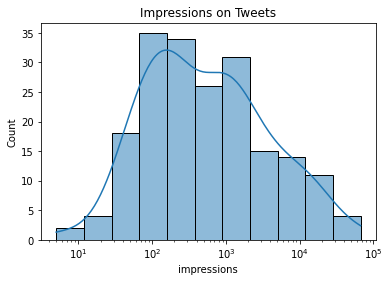

In [ ]:
sns.histplot(df.impressions, kde=True, log_scale=True).set(title="Impressions on Tweets");

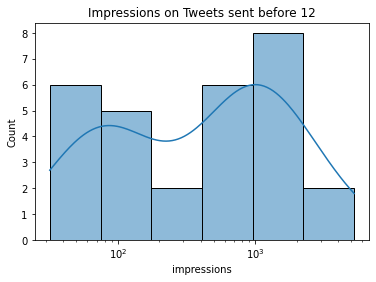

In [ ]:
sns.histplot(tweets_before_12_df.impressions, kde=True, log_scale=True).set(title="Impressions on Tweets sent before 12");

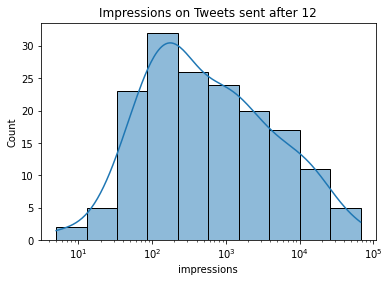

In [ ]:
import seaborn as sns

sns.histplot(tweets_after_12_df.impressions, kde=True, log_scale=True).set(title="Impressions on Tweets sent after 12");

<h1> Segment by Url Tweets </h1>

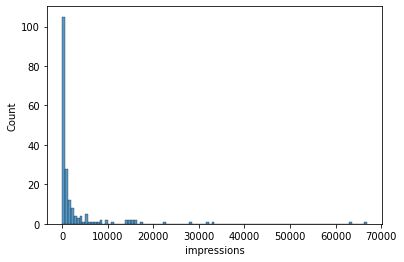

In [ ]:
sns.histplot(df.impressions)

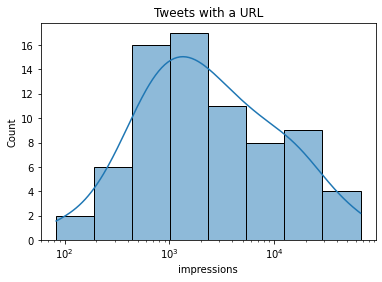

In [ ]:
url_tweets = df.loc[df["url clicks"] > 0]
no_url_tweets = df.loc[df["url clicks"] == 0]

sns.histplot(url_tweets.impressions, kde=True, log_scale=True).set(title="Tweets with a URL");

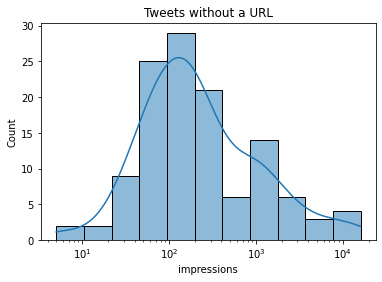

In [ ]:
sns.histplot(no_url_tweets.impressions, kde=True, log_scale=True).set(title="Tweets without a URL");

<h1> Can we Segment Impressions by the Semantics of the Tweets? </h1>

<h1> Load Twitter Data into Weaviate </h1>

In [ ]:
!pip install weaviate-client==3.4.2 > /dev/null

In [ ]:
# create Weaviate instance
from getpass import getpass
import weaviate
from weaviate.wcs import WCS

my_credentials = weaviate.auth.AuthClientPassword(username=input("User name: "), password=getpass("Password: "))

User name: connorshorten300@gmail.com
Password: ··········


In [ ]:
# How to Create a Cluster from Scratch

my_wcs = WCS(my_credentials)
cluster_name = "connors-twitter-analytics"
modules = [{
    "name": "text2vec-transformers",
    "tag": "sentence-transformers-paraphrase-MiniLM-L6-v2"
}]
weaviate_url = my_wcs.create(cluster_name, with_auth=False, modules=modules, wait_for_completion=True)
client = weaviate.Client(weaviate_url)
client.is_ready()

Creating cluster:

  0% |          |[00:00<?, ?%/s]

True

<h1> Pandas DataFrame to Weaviate </h1>

In [ ]:
weaviate_schema = {
      "classes": [
                  {
                      "class": "Tweet",
                      "description": "Tweet Analytics",
                      "properties": [
                                     {
                                         "name": "tweet_text",
                                         "dataType": ["text"],
                                         "description": "The text in the Tweet.",
                                         "moduleConfig": {
                                             "text2vec-transformers": {
                                                 "skip": False,
                                                 "vectorizePropertyName": False
                                             }
                                         }
                                     },
                                     {
                                      "name": "author",
                                         "dataType": ["text"],
                                         "description": "The author of the Tweet.",
                                         "moduleConfig": {
                                             "text2vec-transformers": {
                                                 "skip": True,
                                                 "vectorizePropertyName": False
                                             }
                                         }
                                     },
                                     {
                                         "name": "hour",
                                         "dataType": ["int"],
                                         "description": "hour"
                                     },
                                     {
                                         "name": "minute",
                                         "dataType": ["int"],
                                         "description": "minute"
                                     },
                                     {
                                         "name": "earlier_than_12",
                                         "dataType": ["boolean"],
                                         "description": "earlier than 12"
                                     },
                                     {
                                         "name": "day_of_week",
                                         "dataType": ["text"],
                                         "description": "day of week",
                                         "moduleConfig": {
                                            "text2vec-transformers": {
                                                "skip": True,
                                                "vectorizePropertyName": False
                                            }
                                         }
                                     },
                                     {
                                         "name": "impressions",
                                         "dataType": ["number"],
                                         "description": "Tweet impressions"
                                     },
                                     {
                                         "name": "engagements",
                                         "dataType": ["number"],
                                         "description": "Tweet engagements"
                                     },
                                     {
                                         "name": "engagement_rate",
                                         "dataType": ["number"],
                                         "description": "Tweet engagement rate"
                                     },
                                     {
                                         "name": "retweet_count",
                                         "dataType": ["number"],
                                         "description": "Twitter Retweet Count"
                                     },
                                     {
                                         "name": "replies",
                                         "dataType": ["number"],
                                         "description": "Replies on the Tweet"
                                     },
                                     {
                                         "name": "likes",
                                         "dataType": ["number"],
                                         "description": "Likes on the Tweet"
                                     },
                                     {
                                         "name": "user_profile_clicks",
                                         "dataType": ["number"],
                                         "description": "The number of profile clicks from this Tweet"
                                     },
                                     {
                                         "name": "url_clicks",
                                         "dataType": ["number"],
                                         "description": "The number of url clicks on this Tweet"
                                     },
                      ] 
                  }
      ]
}

client.schema.create(weaviate_schema)

In [ ]:
from weaviate.batch import Batch
from weaviate.util import generate_uuid5

# might need to convert the data to a dictionry first...
def add_tweet(batch: Batch, data: dict) -> str:
  tweet_object = {
      "tweet_text": data["tweet_text"],
      "hour": data["hour"],
      "minute": data["minute"],
      "earlier_than_12": data["earlier_than_12"],
      "day_of_week": data["day_of_week"],
      "impressions": data["impressions"],
      "engagements": data["engagements"],
      "engagement_rate": data["engagement_rate"],
      "retweet_count": data["retweet_count"],
      "replies": data["replies"],
      "likes": data["likes"],
      "user_profile_clicks": data["user_profile_clicks"],
      "url_clicks": data["url_clicks"],
      "author": data["author"]
  }
  tweet_id = data["id"]
  batch.add_data_object(
      data_object=tweet_object,
      class_name="Tweet",
      uuid=tweet_id
  )

<h1> Map Tweets to List of Dictionaries with Weaviate Schema </h1>

In [ ]:
from weaviate.util import generate_uuid5
counter = 0
data_items = []
df["id"] = ""

for idx in range(len((df))):
  id = generate_uuid5(counter)
  df.at[idx, "id"] = id
  data = df.iloc[idx]
  tweet_object = {
      "tweet_text": data["Tweet text"],
      "hour": data["hour"].item(),
      "minute": data["minute"].item(),
      "earlier_than_12": data["earlier than 12"].item(),
      "day_of_week": data["day of week"],
      "impressions": data["impressions"].item(),
      "engagements": data["engagements"].item(),
      "engagement_rate": data["engagement rate"].item(),
      "retweet_count": data["retweets"].item(),
      "replies": data["replies"].item(),
      "likes": data["likes"].item(),
      "user_profile_clicks": data["user profile clicks"].item(),
      "url_clicks": data["url clicks"].item(),
      "author": "CShorten30",
      "id": id
  }
  data_items.append(tweet_object)
  counter += 1

<h1> Upload Data to Weaviate </h1>

In [ ]:
len(data_items)

194

In [ ]:
data_items[0]

{'author': 'CShorten30',
 'day_of_week': 'Tuesday',
 'earlier_than_12': False,
 'engagement_rate': 0.0127226463104325,
 'engagements': 5.0,
 'hour': 17,
 'id': '6af613b6-569c-5c22-9c37-2ed93f31d3af',
 'impressions': 393.0,
 'likes': 1.0,
 'minute': 18,
 'replies': 0.0,
 'retweet_count': 0.0,
 'tweet_text': '@fchollet Nice! Love the idea of models that take embeddings from some other optimization task as inputs! 🔥',
 'url_clicks': 0.0,
 'user_profile_clicks': 3.0}

In [ ]:
client.batch.configure(batch_size=50, dynamic=True)

with client.batch as batch:
  for i in data_items:
    add_tweet(batch, i)

In [ ]:
query_result = client.query.get("Tweet", ["tweet_text"]).do()

In [ ]:
query_result["data"]["Get"]["Tweet"][:5]

[{'tweet_text': 'Really nice thread summarizing key ideas in VL-Adapter! 🧵😎\n\nNew podcast discussing this work with the authors for those interested: https://t.co/JPmpzaI1Wn 🎙 https://t.co/Am4vheV8ZZ'},
 {'tweet_text': 'Exciting new Weaviate project with @ecardenas300 exploring House listings -- text descriptions for now, adding images and graph-structured info about neighborhoods next.\n\nUsing Weaviate to integrate unstructured data to Econometrics! More details soon! https://t.co/8xiylXw9x1'},
 {'tweet_text': 'New substack publication! 🗞️\n\nTLDR: 📰\n• AI Weekly Update paper takeaways\n•\xa0General plan for AI Weekly Update\n•\xa0Weaviate update - upcoming podcast guests, plans for Vector Search API sharing, and Keras Code Search tutorials\n\nhttps://t.co/wGgCBoPEwa'},
 {'tweet_text': '@AslanTricha Excellent idea - would be cool to see with AndroidEnv!'},
 {'tweet_text': '@weaviate_io 🔥🔥🔥 Love the integration of this with the GraphQL API!'}]

<h2> Semantic Search with Weaviate </h2>

In [ ]:
def nearText_wrapper(query):
  nearText = {
      "concepts": query
  }
  nearest_neighbor_search = client.query.get("Tweet", ["tweet_text", "impressions"]).with_near_text(nearText).do()
  return nearest_neighbor_search["data"]["Get"]["Tweet"]

In [ ]:
query = "New Podcast"

tweets = nearText_wrapper(query)
tweets[0:3]

[{'impressions': 8606,
  'tweet_text': 'New Weaviate Podcast! (#14) 🥳 \n\nI had the opportunity to interview the authors (@yilin_sung, @jmin__cho, @mohitban47) of VL-Adapter!\n\nThis is such an exciting work on sparse fine-tuning (only 4% of params needed 🔥) -- I hope you enjoy the podcast! 🎙️👇\n\nhttps://t.co/CBWbLhTBca'},
 {'impressions': 3006,
  'tweet_text': 'Podcasting is one of the fastest rising forms of content! \n\nDeep Learning for Podcast Search enables the ability to search for podcast clips from text, such as:\n"Yann LeCun on the dark matter of intelligence"\n\nThis video explains some ideas around this:\nhttps://t.co/uHAYl6nyY5'},
 {'impressions': 4197,
  'tweet_text': 'Weaviate Podcast #5 is out!\n\nI interviewed Michael Wechner about bringing NLP to Slack chats and detecting duplicate questions within organizations!\n\nI think this could be really impactful, I hope you enjoy the podcast!\nhttps://t.co/NfHsSxOpC5'}]

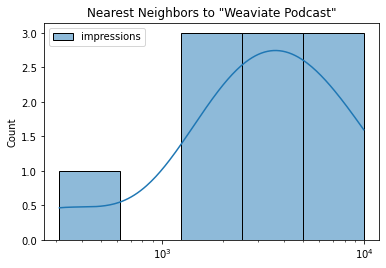

In [ ]:
Weaviate_Podcast_10_Neighbors = pd.DataFrame(nearText_wrapper("Weaviate Podcast")[:10])
Weaviate_Coding_Tutorial_10_Neighbors = pd.DataFrame(nearText_wrapper("Weaviate Coding Tutorials")[:10])
AI_Weekly_Update_10_Neighbors = pd.DataFrame(nearText_wrapper("AI Weekly Update")[:10])


sns.histplot(Weaviate_Podcast_10_Neighbors, kde=True, log_scale=True).set(title='Nearest Neighbors to "Weaviate Podcast"');

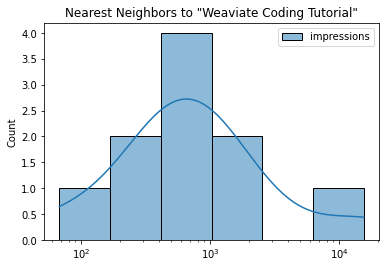

In [ ]:
sns.histplot(Weaviate_Coding_Tutorial_10_Neighbors, kde=True, log_scale=True).set(title='Nearest Neighbors to "Weaviate Coding Tutorial"');

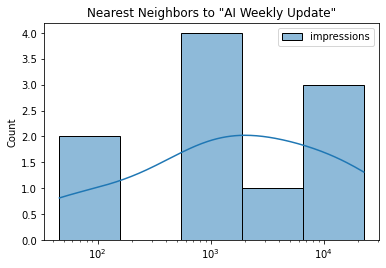

In [ ]:
sns.histplot(AI_Weekly_Update_10_Neighbors, kde=True, log_scale=True).set(title='Nearest Neighbors to "AI Weekly Update"');

<h2> Get Tweets not authored by me </h2>

In [ ]:
!pip install tweepy > /dev/null

In [ ]:
from getpass import getpass

consumer_key = getpass("Consumer Key: ")
consumer_secret = getpass("Consumer Secret: ")
access_token_key = getpass("Access Key: ")
access_token_secret = getpass("Access Secret: ")

Consumer Key: ··········
Consumer Secret: ··········
Access Key: ··········
Access Secret: ··········


In [ ]:
import tweepy
from tweepy.auth import OAuthHandler

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)

api = tweepy.API(auth)

In [ ]:
from weaviate.util import generate_uuid5

friends_tweets = []

friend_counter = 500

usernames = ["etiennedi", "cdpierse", "bobvanluijt", "malte_pietsch", "MichiWechner", "arvind_io",
             "CasualBrady", "MalkovYury", "hxiao", "jefrankle", "RickLamers", "mohitban47",
             "jmin__cho", "yilin_sung", "Maximilianwerk"]

for username in usernames:
  this_persons_tweets = api.user_timeline(username, count=100)
  for tweet in this_persons_tweets:
    id = generate_uuid5(friend_counter)
    friend_counter += 1
    friends_tweets.append({
        "author": username,
        "tweet_text": tweet.text,
        "likes": tweet.favorite_count,
        "id": id
    })

In [ ]:
len(friends_tweets)

1294

In [ ]:
client.batch.configure(batch_size=50, dynamic=True)

# need to deal with uuid and the counter variable from before -- maybe just init at 500 to be safe?
def add_friends_tweet(batch: Batch, data: dict) -> str:
  tweet_object = {
      "tweet_text": data["tweet_text"],
      "likes": data["likes"],
      "author": data["author"]
  }
  tweet_id = data["id"]
  batch.add_data_object(
      data_object=tweet_object,
      class_name="Tweet",
      uuid=tweet_id
  )


with client.batch as batch:
  for i in friends_tweets:
    add_friends_tweet(batch, i)